In [1]:
#IMPORTS

import pandas as pd
import math
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import sys,os
%run ../datuslib.ipynb

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
N_df = pd.read_csv("../Data/train.csv")

In [3]:
N_df.shape

(7613, 5)

In [4]:
N_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
N_df.dropna(subset=['location'], inplace=True)

In [6]:
N_df.shape

(5080, 5)

In [7]:
N_df.location.value_counts()

USA                                                  104
New York                                              71
United States                                         50
London                                                45
Canada                                                29
Nigeria                                               28
UK                                                    27
Los Angeles, CA                                       26
India                                                 24
Mumbai                                                22
Washington, DC                                        21
Kenya                                                 20
Worldwide                                             19
Australia                                             18
Chicago, IL                                           18
California                                            17
California, USA                                       15
Everywhere                     

In [8]:
N_df['full_locations'] = N_df.location.map(getLocation)

In [9]:
N_df['continents'] = N_df['full_locations'].map(lambda x: x[0])
N_df['countries'] = N_df['full_locations'].map(lambda x: x[1])
N_df['cities'] = N_df['full_locations'].map(lambda x: x[2])

#### Que continente tiene más desastres? (frecuencia)

In [10]:
N_df_continentes = N_df[N_df.continents != '__UNKNOWN'].loc[:,['continents', 'target']]

In [11]:
#Tutorial: https://towardsdatascience.com/mapping-avocado-prices-in-python-with-geopandas-geopy-and-matplotlib-c7e0ef08bc26
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent= 'https://DatUs.com/')

continets = N_df_continentes.continents.unique()

continets_dict = {i : geolocator.geocode(i) for i in continets}

continets_df = pd.DataFrame(continets_dict)
continets_df_melted = continets_df.iloc[1:2,:].melt()
continets_df_melted.columns = ['continet', 'co-ordinates']
continets_df_melted

continet                co-ordinates
0         Europe                (51.0, 10.0)
1         Africa    (11.5024338, 17.7578122)
2  North America  (51.0000002, -109.0000002)
3           Asia    (51.2086975, 89.2343748)
4  South America  (-21.0002179, -61.0006565)
5        Oceania        (-18.3128, 138.5156)
6   EuropeEurope                        None
7     Antarctica    (-79.4063075, 0.3149312)

In [12]:
df = pd.merge(N_df_continentes, continets_df_melted, left_on='continents', right_on='continet')

df[['latitude', 'longitude']] = pd.DataFrame(df['co-ordinates'].tolist(), index=df.index)
continents_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
continents_gdf.continents.value_counts()

North America    1928
Europe            465
Asia              395
Africa            211
South America     148
Oceania           135
EuropeEurope       31
Antarctica          2
Name: continents, dtype: int64

In [13]:
N_df_continentes_groupped = N_df_continentes.groupby('continents').agg({'target' : ['count', 'sum', 'mean']})
N_df_continentes_groupped.columns = N_df_continentes_groupped.columns.get_level_values(0) + "_" + N_df_continentes_groupped.columns.get_level_values(1)
N_df_continentes_groupped

target_count  target_sum  target_mean
continents                                          
Africa                  211         115     0.545024
Antarctica                2           2     1.000000
Asia                    395         235     0.594937
Europe                  465         173     0.372043
EuropeEurope             31          13     0.419355
North America          1928         832     0.431535
Oceania                 135          70     0.518519
South America           148          66     0.445946

In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_filtrado = world.loc[:,['continent', 'geometry']]
#fig, ax = plt.subplots(1, 1)

    
continents = world_filtrado.dissolve(by='continent')
continents['tweets_count'] = N_df_continentes_groupped.target_count
continents['target_sum'] = N_df_continentes_groupped.target_sum 
continents['target_mean'] = N_df_continentes_groupped.target_mean 

continents.tweets_count = continents.tweets_count.fillna(0)
continents.target_sum = continents.target_sum.fillna(0)
continents.target_mean = continents.target_mean.fillna(0)
continents

geometry  \
continent                                                                    
Africa                   MULTIPOLYGON (((49.544 -12.470, 49.809 -12.895...   
Antarctica               MULTIPOLYGON (((-163.713 -78.596, -163.713 -78...   
Asia                     MULTIPOLYGON (((120.295 -10.259, 118.968 -9.55...   
Europe                   MULTIPOLYGON (((-51.658 4.156, -52.249 3.241, ...   
North America            MULTIPOLYGON (((-61.680 10.760, -61.105 10.890...   
Oceania                  MULTIPOLYGON (((169.668 -43.555, 170.525 -43.0...   
Seven seas (open ocean)  POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5...   
South America            MULTIPOLYGON (((-66.960 -54.897, -67.291 -55.3...   

                         tweets_count  target_sum  target_mean  
continent                                                       
Africa                          211.0       115.0     0.545024  
Antarctica                        2.0         2.0     1.000000  
Asia                            395.0       235.0     0.594937  
Europe                          465.0       173.0     0.372043  
North America                  1928.0       832.0     0.431535  
Oceania                         135.0        70.0     0.518519  
Seven seas (open ocean)           0.0         0.0     0.000000  
South America                   148.0        66.0     0.445946

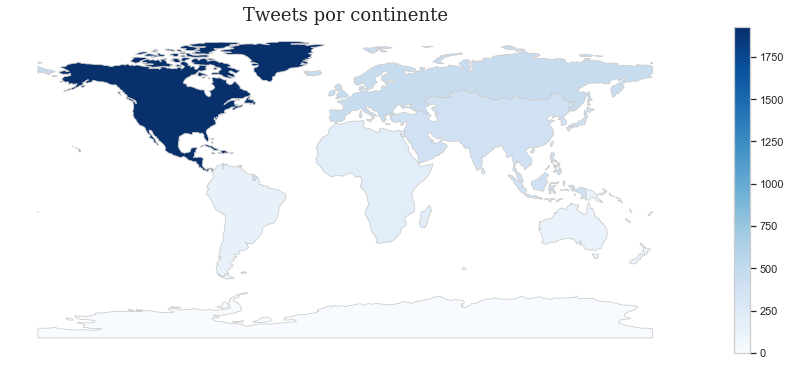

In [15]:
fig, ax = plt.subplots(1, figsize=(18, 6))

continents.plot(column='tweets_count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend = True)
ax.axis('off')

ax.set_title('Tweets por continente', fontsize = 18, fontfamily='serif')
plt.show()

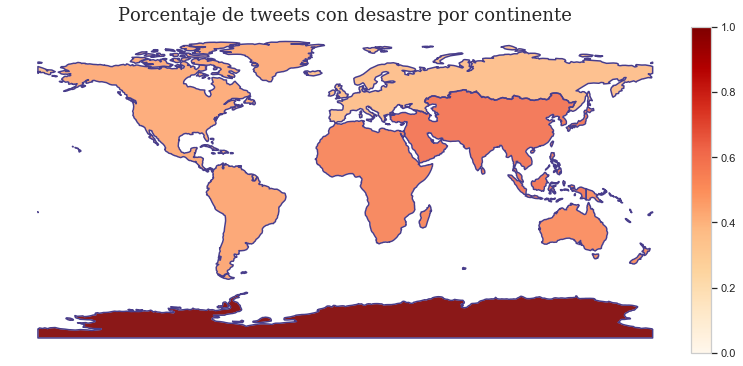

In [16]:
fig, ax = plt.subplots(figsize = (16,6)) 
plt.title('Porcentaje de tweets con desastre por continente', fontsize=18, fontfamily='serif')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
continents.boundary.plot(ax=ax, color='DarkSlateBlue') 
# using the boundary method here to get the outlines of the states, an aesthetic decision
continents.plot(cmap='OrRd', column='target_mean', legend=True, ax=ax, alpha=0.9, cax=cax)

ax.axis('off')

plt.show()

### Groupby por pais y ver cantidad de tweets y desastrocidad por país 

In [17]:
N_df_paises = N_df[N_df.countries != '__UNKNOWN'].loc[:,['countries', 'target']]
N_df_paises['longitud_tweets'] = N_df.text.map(lambda x: len(x))
N_df_paises

countries  target  longitud_tweets
31              United Kingdom       1               55
32              United Kingdom       0               67
34               United States       0               34
35                      Canada       0               76
36                South Africa       0              122
46               United States       1               97
50               United States       1               73
51                       India       1               76
52                    Barbados       0              134
53               United States       1               95
54                     Nigeria       0              130
56                South Africa       1               97
57                      Brazil       0              124
59                      Canada       1              138
63               United States       1              138
64                      Canada       0               80
65              United Kingdom       1               76
66                   Argentina       0               85
68               United States       1               98
69                        Cuba       1              123
71               United States       0              139
72               United States       1              139
73                   Australia       1               35
74               United States       1               90
76                      Brazil       0               67
77                 Philippines       1               67
78               United States       1               95
79                       Kenya       1               91
83               United States       1              132
84               United States       1               79
86               United States       1               67
87                    Maldives       1              142
88              United Kingdom       1              128
89               United States       1               47
91               United States       1               57
94               United States       1               49
95               United States       1              138
96               United States       0              138
97               United States       1              136
101                      Kenya       0              139
104                Switzerland       0              138
113                    Belgium       0               34
114                Switzerland       0              138
118                Switzerland       0              138
119                Switzerland       0              138
120                     Canada       0              139
121              United States       0              123
124              United States       0              131
127              United States       0              110
129              United States       0               61
137              United States       1              136
138              United States       0               80
139              United States       1              136
141                      Spain       1              110
142                      India       1               75
143                      India       1               84
144              United States       1              135
148                  Indonesia       1               95
150              United States       0              126
153                      India       1               87
154                  Sri Lanka       1               83
158                     Canada       1              136
160                      India       1              129
162                      India       1               75
165                     Israel       1               26
167                  Argentina       0              104
168                      Italy       1               87
170                     Canada       1              136
172              United States       1              110
173              United States       1              138
175              United States       0       

In [18]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent= 'https://DatUs.com/')

countries = N_df_paises.countries.unique()

countries_dict = {i : geolocator.geocode(i) for i in countries}

countries_df = pd.DataFrame(countries_dict)
countries_df_melted = countries_df.iloc[1:2,:].melt()
countries_df_melted.columns = ['countries', 'co-ordinates']
countries_df_melted

countries                              co-ordinates
0              United Kingdom                  (54.7023545, -3.2765753)
1               United States                (39.7837304, -100.4458825)
2                      Canada                (61.0666922, -107.9917071)
3                South Africa                  (-28.8166236, 24.991639)
4                       India                  (22.3511148, 78.6677428)
5                    Barbados                 (13.1500331, -59.5250305)
6                     Nigeria                    (9.6000359, 7.9999721)
7                      Brazil                      (-10.3333333, -53.2)
8                   Argentina                (-34.9964963, -64.9672817)
9                        Cuba                 (23.0131338, -80.8328748)
10                  Australia                    (-24.7761086, 134.755)
11                Philippines                 (12.7503486, 122.7312101)
12                      Kenya                   (1.4419683, 38.4313975)
13                   Maldives                   (4.7064352, 73.3287853)
14                Switzerland                   (46.7985624, 8.2319736)
15                    Belgium                   (50.6402809, 4.6667145)
16                      Spain                  (39.3262345, -4.8380649)
17                  Indonesia                 (-2.4833826, 117.8902853)
18                  Sri Lanka                   (7.5554942, 80.7137847)
19                     Israel                  (31.5313113, 34.8667654)
20                      Italy                   (42.6384261, 12.674297)
21                Netherlands                   (52.5001698, 5.7480821)
22                    England         (52.7954791, -0.5402402866174321)
23                   Pakistan                   (30.3308401, 71.247499)
24                    Germany                  (51.0834196, 10.4234469)
25                   Slovenia                  (45.8133113, 14.4808369)
26                      Chile                (-31.7613365, -71.3187697)
27                      Japan                 (36.5748441, 139.2394179)
28                     Poland                    (52.215933, 19.134422)
29                    Finland                  (63.2467777, 25.9209164)
30                     Cyprus                  (34.9823018, 33.1451285)
31                  Singapore                   (1.357107, 103.8194992)
32                    Ireland                   (52.865196, -7.9794599)
33                    Bahamas                 (24.7736546, -78.0000547)
34       United Arab Emirates                  (24.0002488, 53.9994829)
35                      Ghana                   (8.0300284, -1.0800271)
36      Palestinian Territory                                      None
37                   Scotland                  (56.7861112, -4.1140518)
38                     Turkey                  (38.9597594, 34.9249653)
39                  Mauritius                 (-20.2759451, 57.5703566)
40                     Russia                  (64.6863136, 97.7453061)
41                     Brasil                      (-10.3333333, -53.2)
42                     Norway           (64.5731537, 11.52803643954819)
43                    Hungary                  (47.1817585, 19.5060937)
44                   Colombia                   (2.8894434, -73.783892)
45                       Peru                 (-6.8699697, -75.0458515)
46                     France                    (46.603354, 1.8883335)
47                      Egypt                  (26.2540493, 29.2675469)
48                     Jersey        (49.21230655, -2.1255999596428845)
49                   Malaysia                  (4.5693754, 102.2656823)
50                New Zealand                (-41.5000831, 172.8344077)
51                    Liberia                   (5.7499721, -9.3658524)
52                    Austria                   (47.2000338, 13.199959)
53                       Iraq                  (33.0955793, 44.1749775)
54                     Greece                  (38.9953683, 

In [19]:
df = pd.merge(N_df_paises, countries_df_melted, left_on='countries', right_on='countries')

df[['latitude', 'longitude']] = pd.DataFrame(df['co-ordinates'].tolist(), index=df.index)
countries_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
countries_gdf.countries.value_counts()

United States               1614
Canada                       263
United Kingdom               206
Australia                    123
India                        111
Nigeria                       77
England                       67
Argentina                     64
Turkey                        53
Philippines                   52
Brazil                        41
Indonesia                     38
Kenya                         38
Ireland                       32
South Africa                  31
Japan                         28
Ghana                         27
Pakistan                      22
Scotland                      19
Netherlands                   18
Costa Rica                    18
France                        17
Germany                       17
Spain                         16
Italy                         15
China                         13
Russia                        12
Sweden                        12
Colombia                      12
Cuba                          10
New Zealan

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_filtrado = world.loc[:,['name', 'geometry']]

countries = world_filtrado.dissolve(by='name')
countries['name'] = countries.index
countries

geometry  \
name                                                                          
Afghanistan               POLYGON ((66.51861 37.36278, 67.07578 37.35614...   
Albania                   POLYGON ((21.02004 40.84273, 20.99999 40.58000...   
Algeria                   POLYGON ((-8.68440 27.39574, -8.66512 27.58948...   
Angola                    MULTIPOLYGON (((12.32243 -6.10009, 12.73517 -5...   
Antarctica                MULTIPOLYGON (((-163.71290 -78.59567, -163.712...   
Argentina                 MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...   
Armenia                   POLYGON ((46.50572 38.77061, 46.14362 38.74120...   
Australia                 MULTIPOLYGON (((147.68926 -40.80826, 148.28907...   
Austria                   POLYGON ((16.97967 48.12350, 16.90375 47.71487...   
Azerbaijan                MULTIPOLYGON (((46.14362 38.74120, 45.45772 38...   
Bahamas                   MULTIPOLYGON (((-78.19087 25.21030, -77.89000 ...   
Bangladesh                POLYGON ((92.67272 22.04124, 92.65226 21.32405...   
Belarus                   POLYGON ((28.17671 56.16913, 29.22951 55.91834...   
Belgium                   POLYGON ((6.15666 50.80372, 6.04307 50.12805, ...   
Belize                    POLYGON ((-89.14308 17.80832, -89.15091 17.955...   
Benin                     POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1....   
Bhutan                    POLYGON ((91.69666 27.77174, 92.10371 27.45261...   
Bolivia                   POLYGON ((-69.52968 -10.95173, -68.78616 -11.0...   
Bosnia and Herz.          POLYGON ((18.56000 42.65000, 17.67492 43.02856...   
Botswana                  POLYGON ((29.43219 -22.09131, 28.01724 -22.827...   
Brazil                    POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...   
Brunei                    POLYGON ((115.45071 5.44773, 115.40570 4.95523...   
Bulgaria                  POLYGON ((22.65715 44.23492, 22.94483 43.82379...   
Burkina Faso              POLYGON ((-5.40434 10.37074, -5.47056 10.95127...   
Burundi                   POLYGON ((30.46967 -2.41385, 30.52766 -2.80762...   
Cambodia                  POLYGON ((102.58493 12.18659, 102.34810 13.394...   
Cameroon                  POLYGON ((14.49579 12.85940, 14.89336 12.21905...   
Canada                    MULTIPOLYGON (((-132.71001 54.04001, -131.7499...   
Central African Rep.      POLYGON ((27.37423 5.23394, 27.04407 5.12785, ...   
Chad                      POLYGON ((23.83766 19.58047, 23.88689 15.61084...   
Chile                     MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...   
China                     MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...   
Colombia                  POLYGON ((-66.87633 1.25336, -67.06505 1.13011...   
Congo                     POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...   
Costa Rica                POLYGON ((-82.54620 9.56613, -82.93289 9.47681...   
Croatia                   POLYGON ((16.56481 46.50375, 16.88252 46.38063...   
Cuba                      POLYGON ((-82.26815 23.18861, -81.40446 23.117...   
Cyprus                    POLYGON ((32.73178 35.14003, 32.91957 35.08783...   
Czechia                   POLYGON ((15.01700 51.10667, 15.49097 50.78473...   
Côte d'Ivoire             POLYGON ((-8.02994 10.20653, -7.89959 10.29738...   
Dem. Rep. Congo           POLYGON ((29.34000 -4.49998, 29.51999 -5.41998...   
Denmark                   MULTIPOLYGON (((12.37090 56.11141, 12.69001 55...   
Djibouti                  POLYGON ((42.35156 12.54223, 42.77964 12.45542...   
Dominican Rep.            POLYGON ((-71.70830 18.04500, -71.68774 18.316...   
Ecuador                   POLYGON ((-75.37322 -0.15203, -75.23372 -0.911...   
Egypt                     POLYGON ((36.86623 22.00000, 32.90000 22.00000...   
El Salvador               POLYGON ((-89.35333 14.42413, -89.05851 14.340...   
Eq. Guinea                POLYGON ((9.64916 2.28387, 11.27645 2.26105, 1...   
Eritrea                   POLYGON ((36.42951 14.42211, 36.32322 14.82249...   
Estonia                   POLYGON ((27

In [21]:
countries.name.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herz.', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Central African Rep.', 'Chad', 'Chile',
       'China', 'Colombia', 'Congo', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czechia', "Côte d'Ivoire", 'Dem. Rep. Congo', 'Denmark',
       'Djibouti', 'Dominican Rep.', 'Ecuador', 'Egypt', 'El Salvador',
       'Eq. Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Is.',
       'Fiji', 'Finland', 'Fr. S. Antarctic Lands', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran',
       'Iraq', 

In [23]:
countries_out = []
for country in N_df_paises.countries.unique():
    if country not in countries.name.unique():
        countries_out.append(country)
countries_out  

['United States',
 'Barbados',
 'Maldives',
 'England',
 'Singapore',
 'Palestinian Territory',
 'Scotland',
 'Mauritius',
 'Brasil',
 'Jersey',
 'Isle of Man',
 'Bouvet Island',
 'Saint Lucia',
 'Bermuda',
 'Hong Kong',
 'Bahrain',
 'Northern Mariana Islands',
 'Central African Republic']

In [24]:
mappear = {'United States' : 'United States of America', 'Brasil' : 'Brazil', 'England' : 'United Kingdom', 'Hong Kong' : 'China', 'Central African Republic' : 'Central African Rep.'}

N_df_paises.index = N_df_paises.countries
N_df_paises = N_df_paises.rename(columns = {'countries':'paises'})
N_df_paises = N_df_paises.rename(index = mappear)

N_df_paises_groupped = N_df_paises.groupby('countries').agg({'target' : ['count', 'sum', 'mean']})
N_df_paises_groupped.columns = N_df_paises_groupped.columns.get_level_values(0) + "_" + N_df_paises_groupped.columns.get_level_values(1)
N_df_paises_groupped

target_count  target_sum  target_mean
countries                                                      
Afghanistan                          2           2     1.000000
Antarctica                           1           1     1.000000
Argentina                           64          34     0.531250
Australia                          123          65     0.528455
Austria                              1           0     0.000000
Bahamas                              3           1     0.333333
Bahrain                              1           1     1.000000
Bangladesh                           2           2     1.000000
Barbados                             4           1     0.250000
Belgium                              4           2     0.500000
Bermuda                              2           1     0.500000
Bolivia                              2           1     0.500000
Botswana                             1           0     0.000000
Bouvet Island                        1           1     1.000000
Brazil                              50          21     0.420000
Bulgaria                             1           0     0.000000
Cambodia                             1           1     1.000000
Cameroon                             1           1     1.000000
Canada                             263         122     0.463878
Central African Rep.                 2           0     0.000000
Chile                                6           4     0.666667
China                               16           5     0.312500
Colombia                            12           4     0.333333
Costa Rica                          18           6     0.333333
Cuba                                10           6     0.600000
Cyprus                               3           1     0.333333
Denmark                              2           2     1.000000
Ecuador                              4           1     0.250000
Egypt                                7           5     0.714286
Fiji                                 1           0     0.000000
Finland                              7           4     0.571429
France                              17           6     0.352941
Germany                             17          10     0.588235
Ghana                               27          13     0.481481
Greece                               3           3     1.000000
Greenland                            1           0     0.000000
Guatemala                            1           1     1.000000
Honduras                             2           0     0.000000
Hungary                              2           0     0.000000
India                              111          78     0.702703
Indonesia                           38          23     0.605263
Iraq                                 2           2     1.000000
Ireland                             32          13     0.406250
Isle of Man                          1           1     1.000000
Israel                               8           6     0.750000
Italy                               15           8     0.533333
Japan                               28          11     0.392857
Jersey                               9           4     0.444444
Jordan                               3           3     1.000000
Kenya                               38          17     0.447368
Kuwait                               2           2     1.000000
Lebanon                              1           0     0.000000
Liberia                              4           1     0.250000
Libya                                1           1     1.000000
Lithuania                            1           0     0.000000
Malaysia                             8           4     0.500000
Maldives                             2           1     0.500000
Mali                                 1           0     0.000000
Mauritius                            1           1     1.000000
Mexico                               3           1     0.333333
Mongolia                             2           1     0.5

In [25]:
countries['tweets_count'] = N_df_paises_groupped.target_count
countries['target_sum'] = N_df_paises_groupped.target_sum 
countries['target_mean'] = N_df_paises_groupped.target_mean

countries.tweets_count = countries.tweets_count.fillna(0)
countries.target_sum = countries.target_sum.fillna(0)
countries.target_mean = countries.target_mean.fillna(0)
countries

geometry  \
name                                                                          
Afghanistan               POLYGON ((66.51861 37.36278, 67.07578 37.35614...   
Albania                   POLYGON ((21.02004 40.84273, 20.99999 40.58000...   
Algeria                   POLYGON ((-8.68440 27.39574, -8.66512 27.58948...   
Angola                    MULTIPOLYGON (((12.32243 -6.10009, 12.73517 -5...   
Antarctica                MULTIPOLYGON (((-163.71290 -78.59567, -163.712...   
Argentina                 MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...   
Armenia                   POLYGON ((46.50572 38.77061, 46.14362 38.74120...   
Australia                 MULTIPOLYGON (((147.68926 -40.80826, 148.28907...   
Austria                   POLYGON ((16.97967 48.12350, 16.90375 47.71487...   
Azerbaijan                MULTIPOLYGON (((46.14362 38.74120, 45.45772 38...   
Bahamas                   MULTIPOLYGON (((-78.19087 25.21030, -77.89000 ...   
Bangladesh                POLYGON ((92.67272 22.04124, 92.65226 21.32405...   
Belarus                   POLYGON ((28.17671 56.16913, 29.22951 55.91834...   
Belgium                   POLYGON ((6.15666 50.80372, 6.04307 50.12805, ...   
Belize                    POLYGON ((-89.14308 17.80832, -89.15091 17.955...   
Benin                     POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1....   
Bhutan                    POLYGON ((91.69666 27.77174, 92.10371 27.45261...   
Bolivia                   POLYGON ((-69.52968 -10.95173, -68.78616 -11.0...   
Bosnia and Herz.          POLYGON ((18.56000 42.65000, 17.67492 43.02856...   
Botswana                  POLYGON ((29.43219 -22.09131, 28.01724 -22.827...   
Brazil                    POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...   
Brunei                    POLYGON ((115.45071 5.44773, 115.40570 4.95523...   
Bulgaria                  POLYGON ((22.65715 44.23492, 22.94483 43.82379...   
Burkina Faso              POLYGON ((-5.40434 10.37074, -5.47056 10.95127...   
Burundi                   POLYGON ((30.46967 -2.41385, 30.52766 -2.80762...   
Cambodia                  POLYGON ((102.58493 12.18659, 102.34810 13.394...   
Cameroon                  POLYGON ((14.49579 12.85940, 14.89336 12.21905...   
Canada                    MULTIPOLYGON (((-132.71001 54.04001, -131.7499...   
Central African Rep.      POLYGON ((27.37423 5.23394, 27.04407 5.12785, ...   
Chad                      POLYGON ((23.83766 19.58047, 23.88689 15.61084...   
Chile                     MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...   
China                     MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...   
Colombia                  POLYGON ((-66.87633 1.25336, -67.06505 1.13011...   
Congo                     POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...   
Costa Rica                POLYGON ((-82.54620 9.56613, -82.93289 9.47681...   
Croatia                   POLYGON ((16.56481 46.50375, 16.88252 46.38063...   
Cuba                      POLYGON ((-82.26815 23.18861, -81.40446 23.117...   
Cyprus                    POLYGON ((32.73178 35.14003, 32.91957 35.08783...   
Czechia                   POLYGON ((15.01700 51.10667, 15.49097 50.78473...   
Côte d'Ivoire             POLYGON ((-8.02994 10.20653, -7.89959 10.29738...   
Dem. Rep. Congo           POLYGON ((29.34000 -4.49998, 29.51999 -5.41998...   
Denmark                   MULTIPOLYGON (((12.37090 56.11141, 12.69001 55...   
Djibouti                  POLYGON ((42.35156 12.54223, 42.77964 12.45542...   
Dominican Rep.            POLYGON ((-71.70830 18.04500, -71.68774 18.316...   
Ecuador                   POLYGON ((-75.37322 -0.15203, -75.23372 -0.911...   
Egypt                     POLYGON ((36.86623 22.00000, 32.90000 22.00000...   
El Salvador               POLYGON ((-89.35333 14.42413, -89.05851 14.340...   
Eq. Guinea                POLYGON ((9.64916 2.28387, 11.27645 2.26105, 1...   
Eritrea                   POLYGON ((36.42951 14.42211, 36.32322 14.82249...   
Estonia                   POLYGON ((27

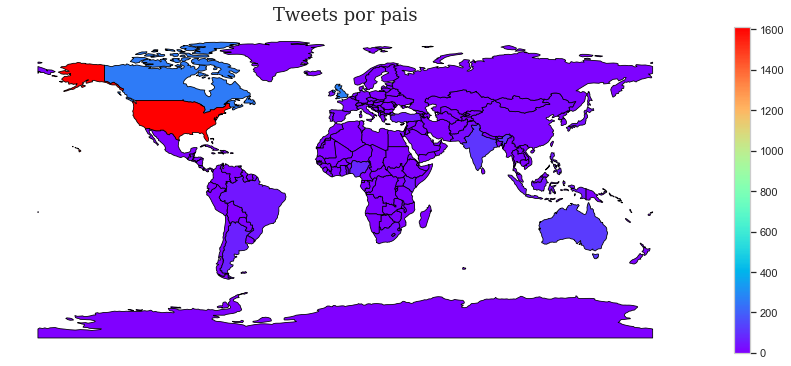

In [26]:
fig, ax = plt.subplots(1, figsize=(18, 6))

countries.plot(column='tweets_count', cmap='rainbow', linewidth=0.8, ax=ax, edgecolor='0', legend = True)
ax.axis('off')

ax.set_title('Tweets por pais', fontsize = 18, fontfamily='serif')
plt.show()

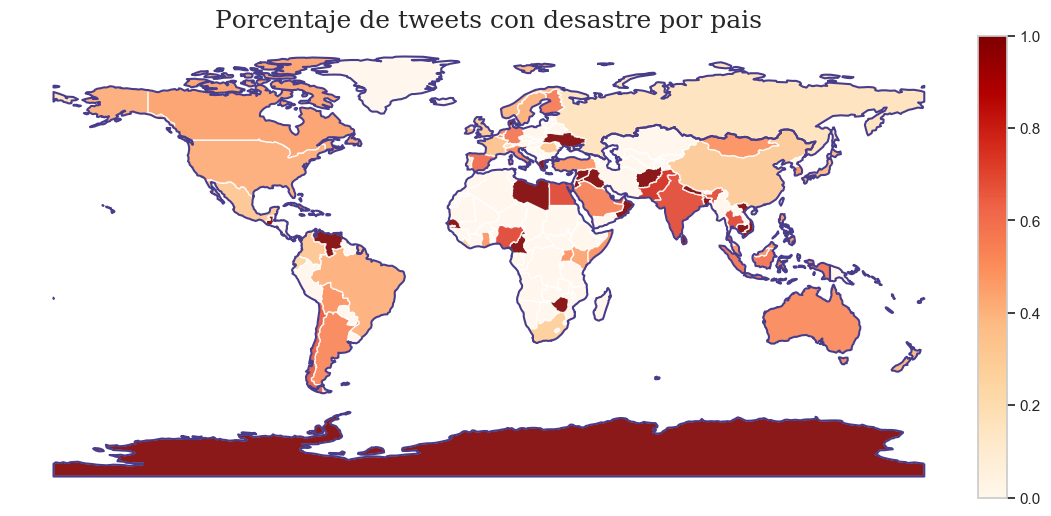

In [282]:
fig, ax = plt.subplots(figsize = (16,6)) 
plt.title('Porcentaje de tweets con desastre por pais', fontsize=18, fontfamily='serif')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
continents.boundary.plot(ax=ax, color='DarkSlateBlue') 
# using the boundary method here to get the outlines of the states, an aesthetic decision
countries.plot(cmap='OrRd', column='target_mean', legend=True, ax=ax, alpha=0.9, cax=cax)

ax.axis('off')

plt.show()

### Distribucion de la longitud de los tweets en los 5 paises con mas tweets

In [315]:
top_ten = N_df_paises_groupped.target_count.nlargest(5)

N_df_paises_top_ten = N_df_paises[N_df_paises.index.isin(dict(top_ten).keys())]
N_df_paises_top_ten


paises  target  longitud_tweets
countries                                                        
United Kingdom            United Kingdom       1               55
United Kingdom            United Kingdom       0               67
United States of America   United States       0               34
Canada                            Canada       0               76
United States of America   United States       1               97
United States of America   United States       1               73
India                              India       1               76
United States of America   United States       1               95
Canada                            Canada       1              138
United States of America   United States       1              138
Canada                            Canada       0               80
United Kingdom            United Kingdom       1               76
United States of America   United States       1               98
United States of America   United States       0              139
United States of America   United States       1              139
Australia                      Australia       1               35
United States of America   United States       1               90
United States of America   United States       1               95
United States of America   United States       1              132
United States of America   United States       1               79
United States of America   United States       1               67
United Kingdom            United Kingdom       1              128
United States of America   United States       1               47
United States of America   United States       1               57
United States of America   United States       1               49
United States of America   United States       1              138
United States of America   United States       0              138
United States of America   United States       1              136
Canada                            Canada       0              139
United States of America   United States       0              123
United States of America   United States       0              131
United States of America   United States       0              110
United States of America   United States       0               61
United States of America   United States       1              136
United States of America   United States       0               80
United States of America   United States       1              136
India                              India       1               75
India                              India       1               84
United States of America   United States       1              135
United States of America   United States       0              126
India                              India       1               87
Canada                            Canada       1              136
India                              India       1              129
India                              India       1               75
Canada                            Canada       1              136
United States of America   United States       1              110
United States of America   United States       1              138
United States of America   United States       0               85
Canada                            Canada       0               89
United States of America   United States       1              124
India                              India       0               72
United Kingdom                   England       0               34
United States of America   United States       0              121
United States of America   United States       0              109
United States of America   United States       0              133
Canada                            Canada       0              102
United States of America   United States       1              110
United States of America   United States       0               43
United Kingdom            United Kingdom       0               90
United K

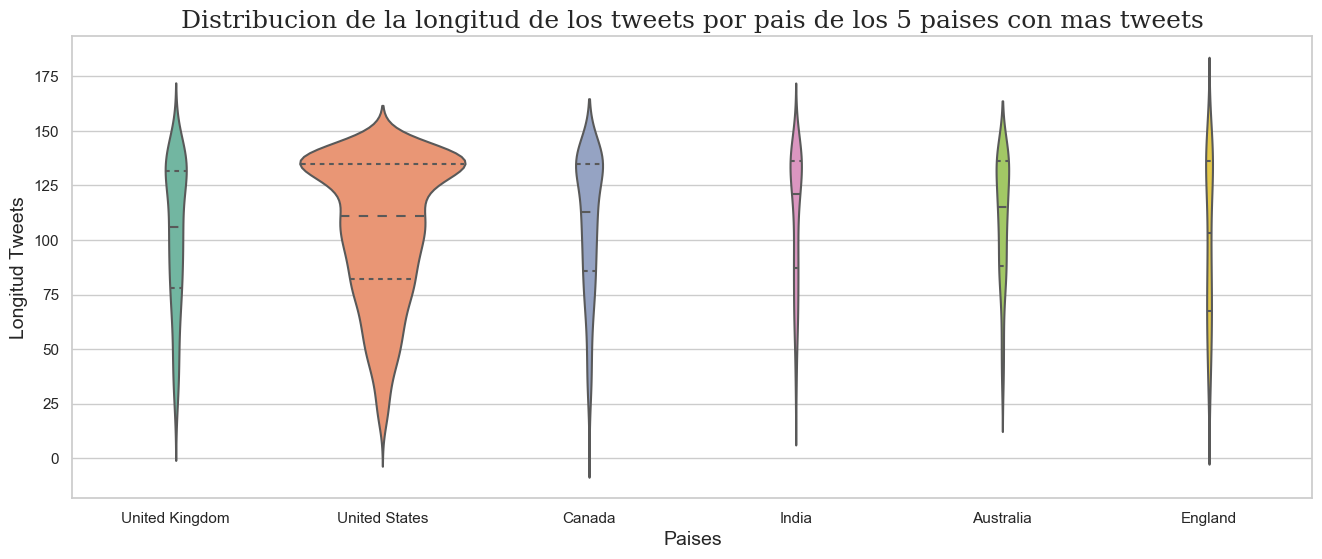

In [322]:
fig, ax = plt.subplots(figsize = (16,6)) 
sns.violinplot(y="longitud_tweets", x='paises',
                    data=N_df_paises_top_ten, palette="Set2",
                    scale="count", inner="quartile")

ax.set_title('Distribucion de la longitud de los tweets por pais de los 5 paises con mas tweets', fontsize = 18, fontfamily='serif')
ax.set_xlabel("Paises", fontsize = 14)
ax.set_ylabel("Longitud Tweets", fontsize = 14)
plt.show()

### Groupby por location y ver cantidad de tweets y desastrocidad por location 

In [329]:
N_df_cities = N_df[N_df.cities != '__UNKNOWN'].loc[:,['cities', 'target']]

In [368]:
cities_groupped = N_df_cities.groupby('cities').agg({'target' : ['count', 'sum', 'mean']})
cities_groupped.columns = cities_groupped.columns.get_level_values(0) + "_" + cities_groupped.columns.get_level_values(1)
cities_groupped = cities_groupped.reset_index(level=['cities'])
cities_groupped

cities  target_count  target_sum  target_mean
0                      Abuja             4           2     0.500000
1                      Accra             4           2     0.500000
2                   Adelaide             6           1     0.166667
3                    Airdrie             1           0     0.000000
4                    Alabama            10           5     0.500000
5                    Alameda             1           1     1.000000
6                     Alaska             5           2     0.400000
7                     Albany             1           0     0.000000
8                Albuquerque             2           1     0.500000
9                 Alexandria             4           3     0.750000
10                  Alicante             1           1     1.000000
11                      Alma             1           1     1.000000
12               Alta Gracia             1           0     0.000000
13                     Alton             1           0     0.000000
14                     Alvin             1           0     0.000000
15   Alzenau in Unterfranken             1           0     0.000000
16                  Amarillo             1           1     1.000000
17                      Ames             1           1     1.000000
18                     Amman             2           2     1.000000
19                 Amsterdam             4           3     0.750000
20                   Anaheim             1           1     1.000000
21                 Anchorage             3           2     0.666667
22                  Anderson             1           1     1.000000
23                      Anna             1           0     0.000000
24                 Annapolis             2           1     0.500000
25                   Antioch             1           0     0.000000
26                     Anzio             2           2     1.000000
27                   Aracaju             1           1     1.000000
28                    Ariana             1           0     0.000000
29                   Arizona            14           6     0.428571
30                  Arkansas             7           5     0.714286
31                 Arlington             5           2     0.400000
32                    Arnhem             1           1     1.000000
33                    Arvada             1           1     1.000000
34                   Ashburn             2           0     0.000000
35                  Asheboro             1           0     0.000000
36                 Asheville             5           3     0.600000
37                   Ashford             1           1     1.000000
38                      Asia            10           6     0.600000
39                    Athens             2           2     1.000000
40                   Atlanta            22           7     0.318182
41                    Auburn             2           1     0.500000
42                  Auckland             4           1     0.250000
43                   Augusta             1           0     0.000000
44                    Aurora             2           0     0.000000
45                    Austin            13           6     0.461538
46                    Aveiro             1           0     0.000000
47                      Avon             2           1     0.500000
48                       Ayr             1           0     0.000000
49               Bakersfield             1           0     0.000000
50                 Baltimore             7           1     0.142857
51                 Balvanera             1           0     0.000000
52                 Banbridge             1           1     1.000000
53            Bandar Lampung             1           1     1.000000
54                   Bandung             2           2     1.000000
55                   Bangkok             2           1     0.500000
56                    Bangor             1           0     0.000000
57                 Barcelona             1           0     0.000000
58        

In [362]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent= 'https://DatUs.com/')

cities = cities_groupped.cities

cities_dict = {i : geolocator.geocode(i) for i in cities}

cities_df = pd.DataFrame(cities_dict)
cities_df_melted = cities_df.iloc[1:2,:].melt()
cities_df_melted.columns = ['cities', 'co-ordinates']
cities_df_melted

cities                               co-ordinates
0                      Abuja                     (9.0643305, 7.4892974)
1                      Accra                    (5.5600141, -0.2057437)
2                   Adelaide                 (-34.9281805, 138.5999312)
3                    Airdrie                     (51.28597, -114.01062)
4                    Alabama                  (33.2588817, -86.8295337)
5                    Alameda                  (37.6090291, -121.899142)
6                     Alaska                  (64.4459613, -149.680909)
7                     Albany                   (42.6511674, -73.754968)
8                Albuquerque                 (35.0841034, -106.6509851)
9                 Alexandria                     (31.199004, 29.894378)
10                  Alicante                    (38.353738, -0.4901846)
11                      Alma           (46.2121955, 24.478076653624996)
12               Alta Gracia                 (-31.6579113, -64.4338499)
13                     Alton                  (38.8908583, -90.1843091)
14                     Alvin                  (29.4238472, -95.2441009)
15   Alzenau in Unterfranken                                       None
16                  Amarillo                 (35.2072185, -101.8338246)
17                      Ames                     (50.536715, 2.4086536)
18                     Amman                   (31.9515694, 35.9239625)
19                 Amsterdam                    (52.3727598, 4.8936041)
20                   Anaheim                  (33.8347516, -117.911732)
21                 Anchorage                 (61.2163129, -149.8948523)
22                  Anderson                  (31.7819242, -95.6258199)
23                      Anna                   (39.0204311, -0.6461361)
24                 Annapolis                   (38.9786401, -76.492786)
25                   Antioch                  (38.0049214, -121.805789)
26                     Anzio                   (41.4471008, 12.6285618)
27                   Aracaju                 (-10.9162061, -37.0774655)
28                    Ariana   (36.968573500000005, 10.121985506329507)
29                   Arizona                  (34.395342, -111.7632755)
30                  Arkansas                  (35.2048883, -92.4479108)
31                 Arlington   (32.701938999999996, -97.10562379033699)
32                    Arnhem                     (51.984257, 5.9108573)
33                    Arvada          (39.8211225, -105.22074299044587)
34                   Ashburn                  (39.0437192, -77.4874899)
35                  Asheboro                  (35.7079146, -79.8136446)
36                 Asheville                  (35.6009498, -82.5540161)
37                   Ashford                     (51.148555, 0.8722566)
38                      Asia                   (51.2086975, 89.2343748)
39                    Athens                   (37.9839412, 23.7283052)
40                   Atlanta                  (33.7490987, -84.3901849)
41                    Auburn            (32.535699, -85.48677785023041)
42                  Auckland                  (-36.852095, 174.7631803)
43                   Augusta                  (33.4709714, -81.9748429)
44                    Aurora                             (16.0, 121.75)
45                    Austin                  (30.2711286, -97.7436995)
46                    Aveiro                    (40.640496, -8.6537841)
47                      Avon                    (48.4048867, 2.7207225)
48                       Ayr                   (55.4628044, -4.6302502)
49               Bakersfield                 (35.3738712, -119.0194639)
50                 Baltimore                   (39.2908816, -76.610759)
51                 Balvanera                 (-34.6092155, -58.4031396)
52                 Banbridge                   (54.3514168, -6.2714623)
53            Bandar Lampung                  (-5.4460713, 105.2643742)
54                   Bandung                  (-6.9344694, 107

In [370]:
df = pd.merge(cities_groupped, cities_df_melted, left_on='cities', right_on='cities')

df[['latitude', 'longitude']] = pd.DataFrame(df['co-ordinates'].tolist(), index=df.index)
cities_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
cities_gdf

cities  target_count  target_sum  target_mean  \
0                      Abuja             4           2     0.500000   
1                      Accra             4           2     0.500000   
2                   Adelaide             6           1     0.166667   
3                    Airdrie             1           0     0.000000   
4                    Alabama            10           5     0.500000   
5                    Alameda             1           1     1.000000   
6                     Alaska             5           2     0.400000   
7                     Albany             1           0     0.000000   
8                Albuquerque             2           1     0.500000   
9                 Alexandria             4           3     0.750000   
10                  Alicante             1           1     1.000000   
11                      Alma             1           1     1.000000   
12               Alta Gracia             1           0     0.000000   
13                     Alton             1           0     0.000000   
14                     Alvin             1           0     0.000000   
15   Alzenau in Unterfranken             1           0     0.000000   
16                  Amarillo             1           1     1.000000   
17                      Ames             1           1     1.000000   
18                     Amman             2           2     1.000000   
19                 Amsterdam             4           3     0.750000   
20                   Anaheim             1           1     1.000000   
21                 Anchorage             3           2     0.666667   
22                  Anderson             1           1     1.000000   
23                      Anna             1           0     0.000000   
24                 Annapolis             2           1     0.500000   
25                   Antioch             1           0     0.000000   
26                     Anzio             2           2     1.000000   
27                   Aracaju             1           1     1.000000   
28                    Ariana             1           0     0.000000   
29                   Arizona            14           6     0.428571   
30                  Arkansas             7           5     0.714286   
31                 Arlington             5           2     0.400000   
32                    Arnhem             1           1     1.000000   
33                    Arvada             1           1     1.000000   
34                   Ashburn             2           0     0.000000   
35                  Asheboro             1           0     0.000000   
36                 Asheville             5           3     0.600000   
37                   Ashford             1           1     1.000000   
38                      Asia            10           6     0.600000   
39                    Athens             2           2     1.000000   
40                   Atlanta            22           7     0.318182   
41                    Auburn             2           1     0.500000   
42                  Auckland             4           1     0.250000   
43                   Augusta             1           0     0.000000   
44                    Aurora             2           0     0.000000   
45                    Austin            13           6     0.461538   
46                    Aveiro             1           0     0.000000   
47                      Avon             2           1     0.500000   
48                       Ayr             1           0     0.000000   
49               Bakersfield             1           0     0.000000   
50                 Baltimore             7           1     0.142857   
51                 Balvanera             1           0     0.000000   
52                 Banbridge             1           1     1.000000   
53            Bandar Lampung             1           1     1.000000   
54                   Bandung             2           2     1.000000   
55                   Bangkok             2    

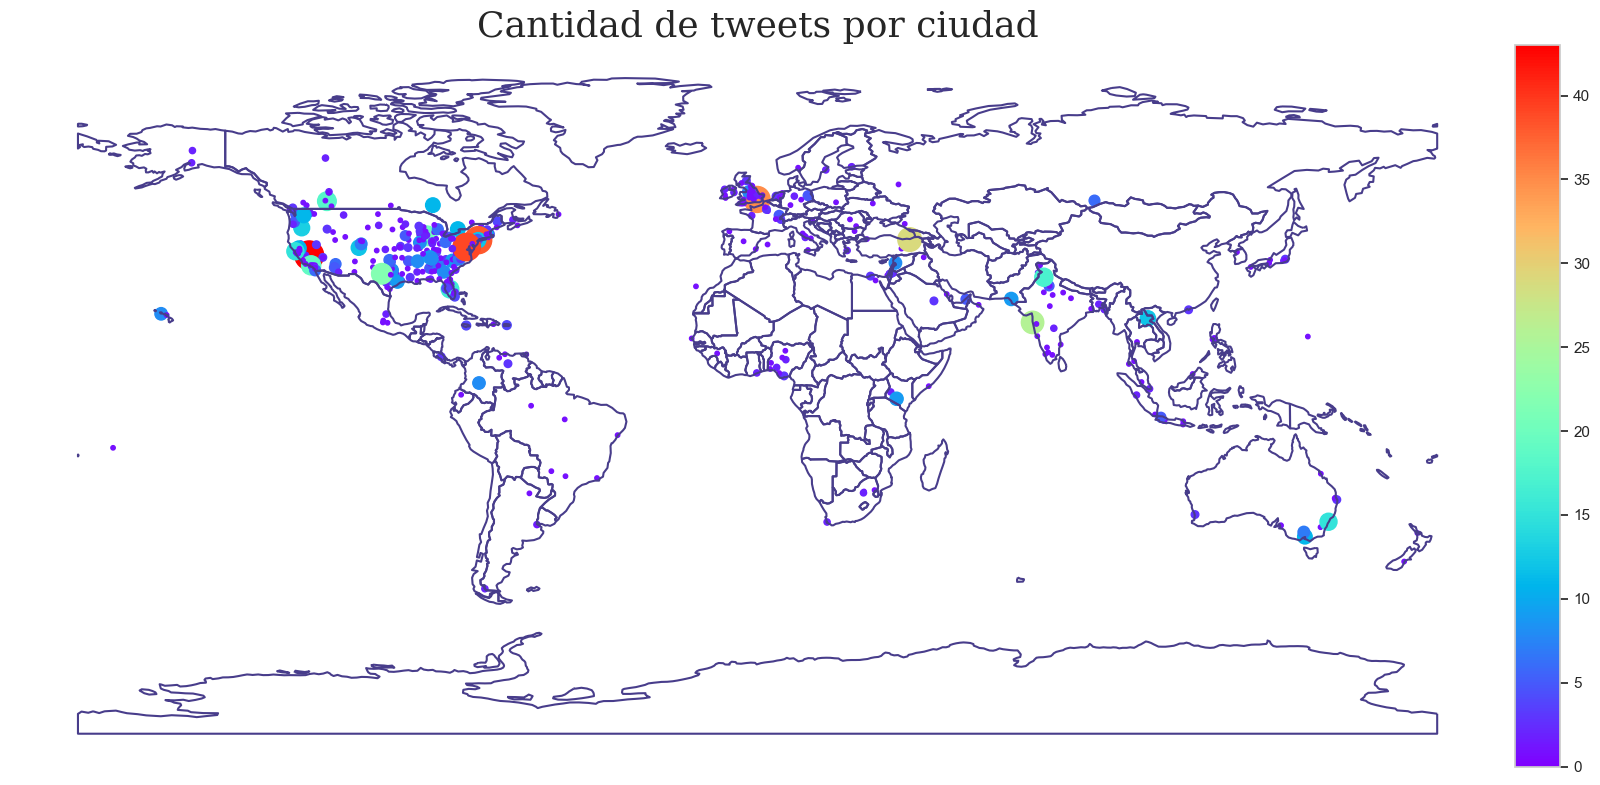

In [389]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

from mpl_toolkits.axes_grid1 import make_axes_locatable 

# This is a function to allow us to make the legend pretty
fig, ax = plt.subplots(figsize = (20,16)) 
plt.title('Cantidad de tweets por ciudad', fontsize=26, fontfamily='serif')

#this part makes the legend the same size as our map, for prettiness
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

world.boundary.plot(ax=ax, color='DarkSlateBlue') 
ax.axis('off')

# using the boundary method here to get the outlines of the states, an aesthetic decision
#cities_gdf = gpd.GeoDataFrame(cities_gdf_groupped)
cities_gdf.plot(cmap='rainbow', column='target_sum', legend=True, ax=ax, alpha=1, cax=cax, markersize=cities_gdf['target_sum']*10)
plt.show()

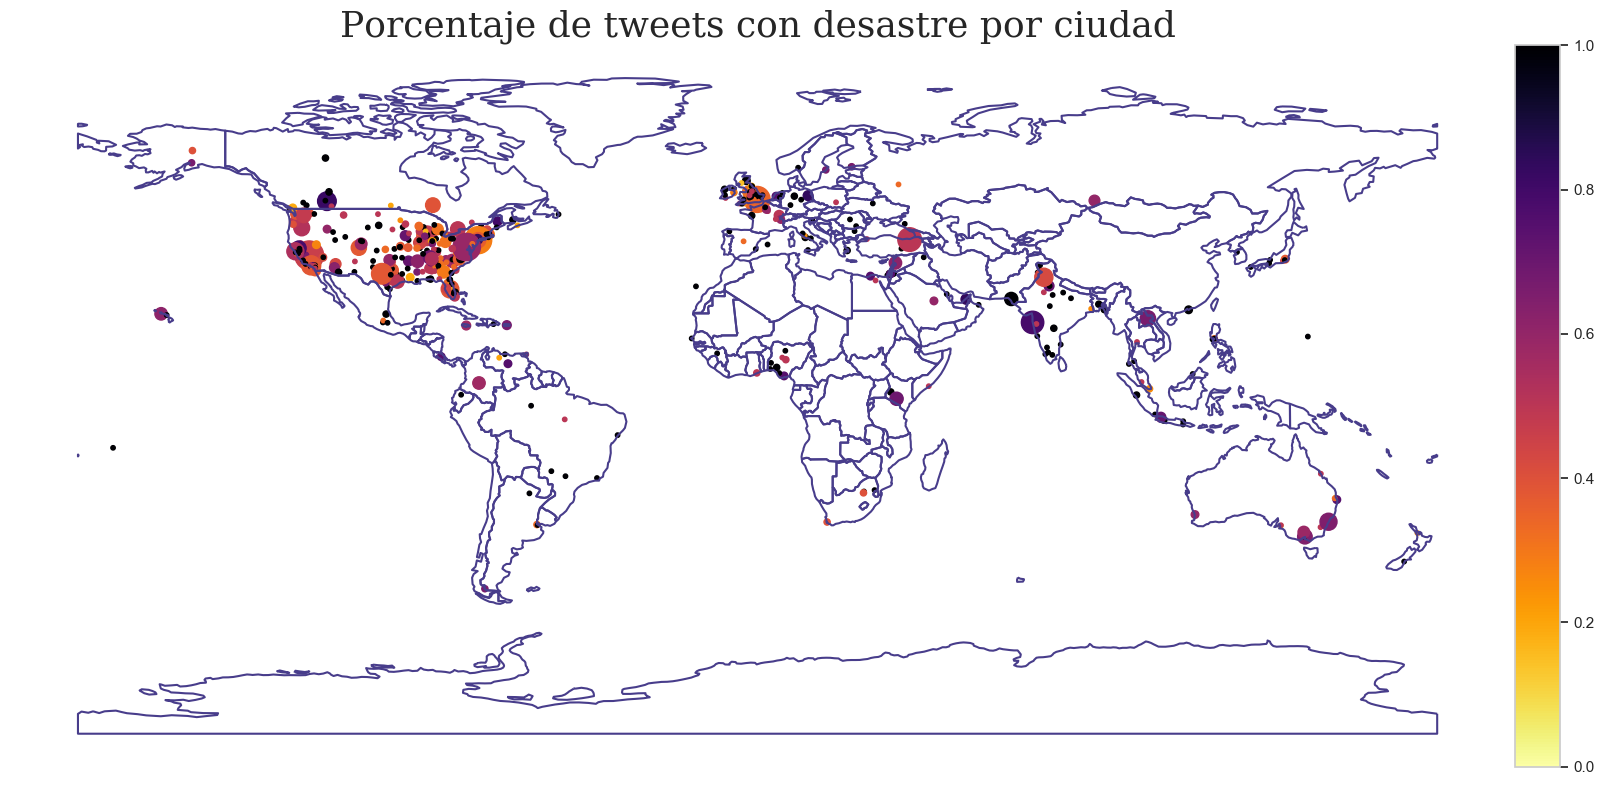

In [391]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

from mpl_toolkits.axes_grid1 import make_axes_locatable 

# This is a function to allow us to make the legend pretty
fig, ax = plt.subplots(figsize = (20,16)) 
plt.title('Porcentaje de tweets con desastre por ciudad', fontsize=26, fontfamily='serif')

#this part makes the legend the same size as our map, for prettiness
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

world.boundary.plot(ax=ax, color='DarkSlateBlue') 
ax.axis('off')

# using the boundary method here to get the outlines of the states, an aesthetic decision
#cities_gdf = gpd.GeoDataFrame(cities_gdf_groupped)
cities_gdf.plot(cmap='inferno_r', column='target_mean', legend=True, ax=ax, alpha=1, cax=cax, markersize=cities_gdf['target_sum']*10)
plt.show()